# Covid 19 X-Ray detection

### The base architecture is VGG 16 upon imagenet dataset


In [1]:
# imports
import psutil
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import time
import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array,  load_img
from keras.applications import VGG16
from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.utils import np_utils, to_categorical
from sklearn.datasets import load_files
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import RMSprop

In [2]:
data_dir =  r'/Users/vimanyuchopra/pythonspace/COVID-19-Detection-From-X-Ray-master/data/X-Ray Image DataSet'
data = load_files(data_dir)
folders=os.listdir("/Users/vimanyuchopra/pythonspace/COVID-19-Detection-From-X-Ray-master/data/X-Ray Image DataSet")
print(folders)

['.DS_Store', 'Covid-19', 'No_findings']


In [3]:
# conversion to numpy array
X = np.array(data['filenames'])
y = np.array(data['target'])
labels = np.array(data['target_names'])
 
# How the arrays look like?
print('Data files - ',X[0])
print('Target labels - ',y[0])
print('total training files : ', X.shape[0])
print('total training ops : ', y.shape[0])

Data files -  /Users/vimanyuchopra/pythonspace/COVID-19-Detection-From-X-Ray-master/data/X-Ray Image DataSet/No_findings/00002550_000.png
Target labels -  1
total training files :  625
total training ops :  625


In [4]:
def imagestoarrays(file_path_list):
    arr = []
    img_width, img_height = 150,150 
    # accessing images
    for file_path in file_path_list:
        """
           Load the image, swap color channels, and resize it to be a fixed
           150*150 pixels while ignoring aspect ratio
        """
        img = load_img(file_path, target_size = (img_width, img_height))
        img = img_to_array(img)
        
        #adding images to array
        arr.append(img)
    return arr

X = np.array(imagestoarrays(X))



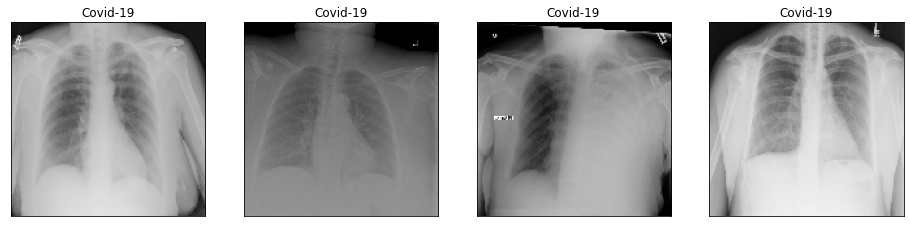

In [5]:
# examples
fig = plt.figure(figsize = (16,9))
for i in range(4):
    ax = fig.add_subplot(1,4,i+1,xticks=[],yticks=[])
    ax.imshow((X[i].astype(np.uint8)))
    plt.title(folders[y[i]])

In [6]:
#normalzining data
X = X.astype('float32')/255
no_of_classes = len(np.unique(y))
# one hot encoding on tatget
y = np.array(np_utils.to_categorical(y,no_of_classes))
y[0]

In [8]:
# split fata into training and testing 80:20
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
print('The train Data Shape ', X_train.shape[0])
 
X_test, X_valid, y_test, y_valid = train_test_split(X_test,y_test, test_size = 0.5)
print('The validation Data Shape ', X_valid.shape[0])
print('The test Data Shape ', X_test.shape[0])

The train Data Shape  500
The validation Data Shape  63
The test Data Shape  62


### **CNN Implementation**

In [9]:
# cnn model
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=X_train.shape[1:], activation='relu', name='Con1'))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', name='Con2'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2), name='Max1'))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', name='Con3'))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='Con4'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2), name='Max2'))
model.add(Dropout(0.25))
    
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', name='Con5'))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', name='Con6'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2), name='Max3'))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=no_of_classes, activation='softmax'))

2022-12-11 22:54:09.561018: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-11 22:54:09.561882: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


In [10]:
# performance
optim = RMSprop(lr=0.001, rho=0.85, epsilon=1e-08, decay=0.0)
model.compile(optim, loss='categorical_crossentropy', metrics=['accuracy'])
learning_rate_reduction=ReduceLROnPlateau(monitor='val_accuracy', patience = 3, verbose = 1, factor = 0.5, minlr = 0.00001)

/Users/vimanyuchopra/pythonspace/env/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


---

In [11]:
# training model
import time
epochs = 110
batch_size=32

# augmenting images before the training the model
gen_train = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.2, 
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True)

gen_test = ImageDataGenerator()

gen = gen_train.flow(
    X_train,y_train,
    batch_size=batch_size)

valid = gen_test.flow(
    X_valid,y_valid,
    batch_size=batch_size)
# fitting the model to augmented images

history=model.fit_generator(gen,
                            epochs=epochs,
                            validation_data = valid,
                            steps_per_epoch=len(X_train) // batch_size,
                            validation_steps=len(X_valid) //batch_size)
                           


/var/folders/7j/m_pjhmxs3wx_g6mpv59b76h80000gn/T/ipykernel_40069/714139840.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(gen,
2022-12-11 22:54:11.123546: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/110


2022-12-11 22:54:11.944349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 13s 424ms/step - loss: 0.8244 - accuracy: 0.7308 - val_loss: 0.5779 - val_accuracy: 0.8125
Epoch 2/110


2022-12-11 22:54:24.249934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 5s 356ms/step - loss: 0.5444 - accuracy: 0.7906 - val_loss: 0.4705 - val_accuracy: 0.8125
Epoch 3/110
15/15 [==============================] - 5s 352ms/step - loss: 0.4820 - accuracy: 0.7885 - val_loss: 0.3244 - val_accuracy: 0.7812
Epoch 4/110
15/15 [==============================] - 5s 352ms/step - loss: 0.5109 - accuracy: 0.7692 - val_loss: 0.3237 - val_accuracy: 0.8438
Epoch 5/110
15/15 [==============================] - 5s 347ms/step - loss: 0.4200 - accuracy: 0.8034 - val_loss: 0.3077 - val_accuracy: 0.7812
Epoch 6/110
15/15 [==============================] - 5s 352ms/step - loss: 0.3770 - accuracy: 0.8291 - val_loss: 0.1867 - val_accuracy: 0.9062
Epoch 7/110
15/15 [==============================] - 5s 347ms/step - loss: 0.4234 - accuracy: 0.8248 - val_loss: 0.2750 - val_accuracy: 0.8125
Epoch 8/110
15/15 [==============================] - 5s 352ms/step - loss: 0.4589 - accuracy: 0.7906 - val_loss: 0.2664 - val_accuracy: 0.8750
Epoch 9/110

In [13]:
# results
(loss, acc) = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=2)
print("Accuracy: {}%".format(acc * 100)) 
print("Loss: {}".format(loss))

2/2 - 0s - loss: 0.0531 - accuracy: 0.9677 - 211ms/epoch - 106ms/step
Accuracy: 96.77419066429138%
Loss: 0.053091224282979965


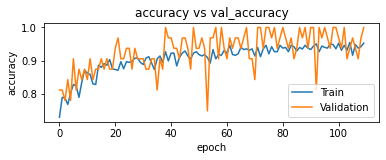

In [16]:
# graphs

import matplotlib.pyplot as plt 
def plot(history):
    plt.figure(1) 
     # accuray graphh
 
    plt.subplot(211)  
    plt.plot(history.history['accuracy'])  
    plt.plot(history.history['val_accuracy'])  
    plt.title('accuracy vs val_accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')  
    plt.legend(['Train', 'Validation'], loc='lower right')  

plot(history)

2/2 [==============================] - 0s 81ms/step


2022-12-11 23:05:27.217410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


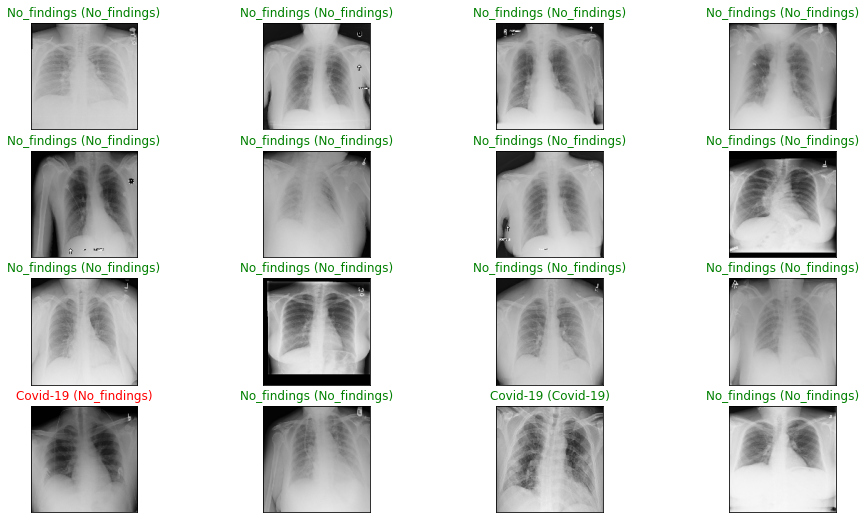

In [15]:
# predictions
def predict(y_pred):

    fig = plt.figure(figsize=(16, 9))
    for i, ab in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[ab]))
        preds = np.argmax(y_pred[ab])
        check = np.argmax(y_test[ab])
        ax.set_title("{} ({})".format(labels[preds], labels[check]),
                     color=("green" if preds == check else "red"))

predict(model.predict(X_test))